In [ ]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import csv
import pandas as pd
import numpy as np

from collections import Counter

#google halloej 
from google.colab import drive
drive.mount('/content/drive')


list=[]
result = [list]
#articles =pd.read_csv('/content/drive/MyDrive/data science colab notesbooks/1mio-raw.csv')
for chunk in pd.read_csv(articles, chunksize=1000):
  result.append(chunk)



#total = sum(result)


#articles = df_1.fillna('a')

#zipfile = ZipFile(BytesIO(resp.read()))
#articles = pd.read_csv(zipfile.open(zipfile.namelist()[0]))

# Subset for faster processing



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#print(result[400]['content'])


In [ ]:
#print(ubaad_new1) 
#print(ubaad_new2)


t = range(0,200)
pu = result[1]

import itertools

correct_next_element = 0

#skifte element i result[i] 
new_List = (range(0,1001)) # Vi er sgu ikke helt sikre på det her 
list_cycle = itertools.cycle(new_List)
next(list_cycle)

for i in result:

#Gammelt stuff
   #print(pu['type'])
   #pu['label'] = 'real'
   #pu.loc[pu['type'] == 'fake', 'label'] = 'fake'
   
#Hvad vi definerer som korrekte labels
   pu['label'] = 'fake'
   pu.loc[pu['type'] == 'real', 'label'] = 'real'
   pu.loc[pu['type'] == 'political', 'label'] = 'real'
   pu.loc[pu['type'] == 'reliable', 'label'] = 'real'

#Andet gammelt stugff
   #pu = result[w]
   #pu2 = result[w + 1]

#skifte element i result[i]
   next_element = next(list_cycle)
   #print(next_element)
   correct_next_element = next_element
   #print(correct_next_element)
   
   pu = result[correct_next_element]
   #print(pu)

#print(result[2]['label'])




In [ ]:
#print(result[1]['content'])


# **DistilBERT delen**

In [ ]:
# Install the transformer package (the models used for creating the embeddings)
!pip install transformers

     |████████████████████████████████| 2.5MB 30.1MB/s 
     |████████████████████████████████| 901kB 43.3MB/s 
     |████████████████████████████████| 3.3MB 51.6MB/s 


In [ ]:
import transformers as ppb # pytorch transformers
import torch

# Create tokenizer and model input
tokenizer = ppb.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')

# Switch to eval mode (rather than training mode) - this potentially gives a slight speedup
model.eval()

# Tokenize input
tokenized = result[1]['content'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# Pad input so that all sequences are of the same size:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

# Actually, we can only deal with sequence lengths up to 512 with the DistilBert model, so we'll just truncate 
padded = padded[:,:512]

# Tell embedding model to disregard pad tokens
attention_mask = np.where(padded != 0, 1, 0)

print(padded.shape)
print(padded)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors


(1000, 512)
[[ 101 2166 2003 ...    0    0    0]
 [ 101 6854 1010 ...    0    0    0]
 [ 101 1996 3050 ...    0    0    0]
 ...
 [ 101 8112 5307 ... 2053 3433 1012]
 [ 101 8275 2739 ... 2344 2000 4894]
 [ 101 3384 2721 ...    0    0    0]]


In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
  model = model.cuda()
  device = torch.device("cuda")

# Convert input to a pytorch tensor (so that it can be used as input for the embedding model)
input = torch.tensor(np.array(padded), device=device)
attention_mask = torch.tensor(attention_mask, device=device)

# Embed sequences (processing in batches to avoid memory problems)
batch_size= 200
embeddings = []
for start_index in range(0, input.shape[0], batch_size):
  with torch.no_grad():
    # Call embedding model
    embedding = model(input[start_index:start_index+batch_size], 
                      attention_mask=attention_mask[start_index:start_index+batch_size])[0][:,0,:]
    embeddings.append(embedding)
embeddings = torch.cat(embeddings)   # concatenate all batch outputs back into one tensor

# Move embeddings back to numpy
embeddings = embeddings.cpu().numpy()

print(embeddings.shape)

(1000, 768)


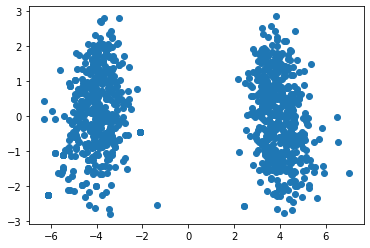

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
dim_reduced_embedding = pca.fit_transform(embeddings) 
plt.scatter(dim_reduced_embedding[:,0], dim_reduced_embedding[:,1])

# SPLIT TRAIN TEST delen **bold text**

In [ ]:
from sklearn.model_selection import train_test_split


sum_y_train = []
sum_y_val = []
sum_y_test = []


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  embeddings , result[1]['label'], test_size=0.40, random_state=42)

In [ ]:
# Use the 40% test set to split further into test and validation set with 50/50 split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)



#print(len(y_train))
#print(len(y_val))
#print(len(y_test))

sum_y_train.append(len(y_train))
sum_y_val.append(len(y_val))
sum_y_test.append(len(y_test))

In [ ]:
print(sum_y_train)
print(sum_y_val)
print(sum_y_test)

[600]
[200]
[200]


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the classifier classes
svc = SVC(kernel='linear') # Linear reg

# Fit the model
svc.fit(X_train,y_train)

# Predict on the test set
svc_pred = svc.predict(X_test)

# Evaluate performance
print("svc accuracy:" + str(accuracy_score(y_test,svc_pred)))

svc accuracy:0.93
